In [1]:
import csv 
import seaborn as sns
import os
import matplotlib.pyplot as plt
import country_converter as coco
import pandas as pd
import sys
import re

sys.path.append('../')
from utils.reader import get_lines

In [2]:
dataset = "../dataset/"

# Get the dataset file structure.
for dirname, _, filenames in os.walk(dataset):
    for filename in filenames:
        print(os.path.join(dataset, filename))


../dataset/.gitkeep
../dataset/foursquare-location-matching.zip
../dataset/pairs.csv
../dataset/sample_submission.csv
../dataset/test.csv
../dataset/train.csv


## 1. Check the dataset and data shape

In [3]:
train = pd.read_csv(os.path.join(dataset, "train.csv"))
test = pd.read_csv(os.path.join(dataset, "test.csv"))
sample = pd.read_csv(os.path.join(dataset, "sample_submission.csv"))
pairs = pd.read_csv(os.path.join(dataset, "pairs.csv"))

# Display the data set scale.
print("train.csv:", train.shape)
print("test.csv:", test.shape)
print("sample_submission.csv:", sample.shape)
print("pairs.csv:", pairs.shape)

train.csv: (1138812, 13)
test.csv: (5, 12)
sample_submission.csv: (5, 2)
pairs.csv: (578907, 25)


In [4]:
for h in train.head(2).keys():
    print(h)

id
name
latitude
longitude
address
city
state
zip
country
url
phone
categories
point_of_interest


In [31]:
train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


In [6]:
test.head(2)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories
0,E_00001118ad0191,Jamu Petani Bagan Serai,5.012169,100.535805,NaN,NaN,NaN,NaN,MY,NaN,NaN,Cafés
1,E_000020eb6fed40,Johnny's Bar,40.434209,-80.564160,497 N 12th St,Weirton,WV,26062.0,US,NaN,NaN,Bars


In [7]:
sample.head(2)

,id,matches
0,E_00001118ad0191,E_00001118ad0191
1,E_000020eb6fed40,E_000020eb6fed40


In [8]:
pairs.head(2)

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,...,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,...,3.635206,NaN,NaN,NaN,NaN,BE,NaN,NaN,Bars,True
1,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,...,27.845560,batı aydın,aydın,NaN,67500,TR,NaN,NaN,Electronics Stores,False


## 2. Check the data type and validate the dataset quality

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138812 entries, 0 to 1138811
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   id                 1138812 non-null  object 
 1   name               1138811 non-null  object 
 2   latitude           1138812 non-null  float64
 3   longitude          1138812 non-null  float64
 4   address            742191 non-null   object 
 5   city               839623 non-null   object 
 6   state              718226 non-null   object 
 7   zip                543386 non-null   object 
 8   country            1138801 non-null  object 
 9   url                267724 non-null   object 
 10  phone              342855 non-null   object 
 11  categories         1040505 non-null  object 
 12  point_of_interest  1138812 non-null  object 
dtypes: float64(2), object(11)
memory usage: 112.9+ MB


In [9]:
missing_values = train.isnull().sum() / len(train) * 100 
missing_values = missing_values.sort_values(ascending=False)
missing_values.to_dict()

{'url': 76.4909396810009,
 'phone': 69.89362598918873,
 'zip': 52.28483718120287,
 'state': 36.93199579913102,
 'address': 34.827609824975504,
 'city': 26.272027340772663,
 'categories': 8.632416939758276,
 'country': 0.000965918869839798,
 'name': 8.781080634907254e-05,
 'id': 0.0,
 'latitude': 0.0,
 'longitude': 0.0,
 'point_of_interest': 0.0}

This mean lots of columns with missing values, and the data is not clean. What is more, the url has the large amount of missing values.

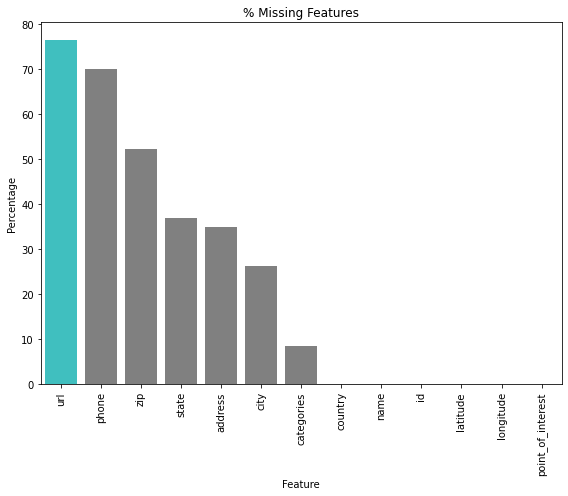

In [11]:
plt.figure(figsize=(8,7))
color=["gray"]*len(missing_values.index)
color[0]="aqua"
sns.barplot(x=missing_values.index, y=missing_values.values,palette=color, saturation=.5)#, palette=clrs) # color=clrs)
plt.xticks(rotation=90)
plt.title("% Missing Features")
plt.xlabel('Feature')
plt.ylabel('Percentage')

plt.tight_layout()

In [14]:
longitudes = pairs['longitude_1'].to_list()
latitudes = pairs['latitude_1'].to_list()
ids = pairs['id_1'].to_list()

count = 0
for lgt, lat, id in zip(longitudes, latitudes, ids):
    if not pd.api.types.is_float(lgt) or not pd.api.types.is_float(lat) or not pd.api.types.is_re(re.compile(r'E_*')):
        print(lgt, lat, id)
        count += 1
print(count/len(longitudes))

0.0


In [40]:
longitudes = train['longitude'].to_list()
latitudes = train['latitude'].to_list()
ids = train['id'].to_list()
names = train['name'].to_list()
categories = train['categories'].to_list()
count = 0
for lgt, lat, id, name, cat in zip(longitudes, latitudes, ids, names, categories):
    if not pd.api.types.is_number(lgt) or not pd.api.types.is_number(lat) or not pd.api.types.is_re(re.compile(r'E_*')):
        print(lgt, lat, id, name, cat)
        count += 1
print(count/len(longitudes)* 100 , '%')

0.0 %


The two cells above mean that the each row data of the datasets has no shift.

## 3. The location data, analysis the unique data among the datasets.

In [44]:
print("the rate of unique POIs among all:", round(len(train['point_of_interest'].unique()) / len(train['point_of_interest']), 4)*100, "%")

the rate of unique POIs among all: 64.98 %


In [41]:
print("unique POIs number:", len(train['point_of_interest'].unique()))

unique POIs number: 739972


In [45]:
poi_groups  = train.groupby(train['point_of_interest'].to_list(), as_index=False)
poi_groups_size = poi_groups.size()
poi_groups_size_top_10 = poi_groups_size.sort_values('size',ascending=False).head(20)
poi_groups_size_top_10

,index,size
726109,P_fb339198a31db3,332
168183,P_3a3fbd26e16269,199
714121,P_f70a0977377171,166
423601,P_9290e406eb58ac,145
728165,P_fbe61733fcdebe,132
259615,P_59cb47cbf3a432,130
717470,P_f82d146eaf21da,120
185692,P_40323f7f948c18,120
718690,P_f8a0cd160eec80,119
312569,P_6c385e5fd3a4b7,119


In [18]:
round(poi_groups_size[poi_groups_size['size'] > 2]['size'].sum() / poi_groups_size['size'].sum(), 2)

0.14

In [48]:
train[train['point_of_interest'] == 'P_fb339198a31db3'].head(20) 

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
10820,E_02761e40f68230,Sukarno Hatta airport,-7.329110,108.213608,NaN,NaN,NaN,NaN,ID,NaN,NaN,Airport Terminals,P_fb339198a31db3
14686,E_0351377fc6b71d,Bandara Soekarno Hatta,-6.143365,106.729291,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3
19520,E_046132a06d8bc5,Bandar Djakarta,-6.117818,106.855710,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3
21192,E_04c39deab3aba2,"Bandara Soekarnao Hatta...^^,",-6.234635,106.874453,NaN,NaN,NaN,NaN,ID,NaN,NaN,Airport Terminals,P_fb339198a31db3
21433,E_04d15c990bfd9e,Bandara Soekarno Hatta,1.541611,98.915245,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3
21679,E_04e0dc77ae3b41,Soekarno Hatta International Airport,-6.162889,106.663583,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3
25621,E_05bd0fb0583a00,Bandara Soekarno-Hatta,-6.132030,106.656560,NaN,NaN,NaN,NaN,ID,NaN,NaN,Airports,P_fb339198a31db3
28095,E_064c0b1349b6bc,Airport Soekarno Hatta,-6.084393,106.643902,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3
32084,E_072ee0f2f2d57b,Bandara Soekarno Hatta,-2.968360,104.749641,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3
35512,E_07f58814417602,Soekarno-Hatta International Airport,-6.123611,106.661111,Cengkareng Tanggerang Banten,NaN,NaN,NaN,ID,NaN,NaN,Bakeries,P_fb339198a31db3


In [21]:
cc = coco.CountryConverter()

country_stats=train['country'].value_counts()*100/train['country'].value_counts().sum()

country_stats.index = coco.convert(names=country_stats.index, to='ISO3')
country_stats=country_stats.reset_index().rename(columns={'index':'country','country':'% data'})
country_stats.head()

XX not found in ISO2
AN not found in ISO2
EU not found in ISO2


,country,% data
0,USA,21.538794
1,TUR,10.113883
2,IDN,9.729180
3,JPN,6.149626
4,THA,5.164028


In [22]:
import plotly.graph_objects as go
import pandas as pd
fig = go.Figure(data=go.Choropleth(
    locations = country_stats['country'],
    z = country_stats['% data'],
    text = country_stats['country'],
    colorscale = 'greens',
    autocolorscale=False,
    marker_line_color='lightgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '%',
    colorbar_title = 'Data availability',
))
fig.update_layout(title_text='% Data by Country')
fig.show()

In [25]:
state_stats = train['state'].value_counts()*100/train['state'].value_counts().sum()
state_stats.head(20)

CA           4.018652
NY           3.031219
FL           2.395346
TX           2.367082
東京都          2.209332
Bangkok      1.640709
PA           1.462075
IL           1.373941
MI           1.124019
Selangor     1.091161
OH           1.052733
NJ           0.978383
GA           0.943993
Türkiye      0.942322
West Java    0.910438
NC           0.905008
Indonesia    0.883009
SP           0.874377
WA           0.840265
VA           0.818266
Name: state, dtype: float64

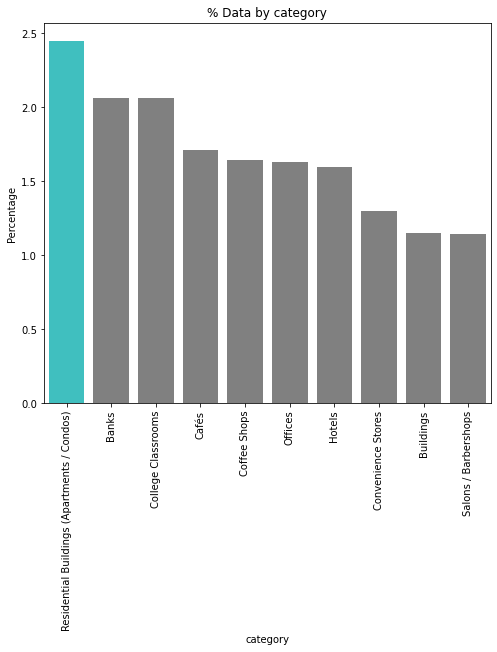

In [26]:
category_stats=train['categories'].value_counts()*100/train['categories'].value_counts().sum()
category_stats=train['categories'].value_counts()*100/train['categories'].value_counts().sum()
category_stats=category_stats.head(10)

plt.figure(figsize=(8,7))
color=["gray"]*len(category_stats.index)
color[0]="aqua"
sns.barplot(x=category_stats.index, y=category_stats.values,palette=color, saturation=.5)#, palette=clrs) # color=clrs)
plt.xticks(rotation=90)
plt.title("% Data by category")
plt.xlabel('category')
_=plt.ylabel('Percentage')

In [27]:
train['categories'].value_counts().head(30)

Residential Buildings (Apartments / Condos)    25481
Banks                                          21494
College Classrooms                             21438
Cafés                                          17805
Coffee Shops                                   17097
Offices                                        16954
Hotels                                         16583
Convenience Stores                             13530
Buildings                                      11981
Salons / Barbershops                           11922
Shopping Malls                                 11385
Gas Stations                                   10326
Fast Food Restaurants                           9963
Hospitals                                       9676
Restaurants                                     9423
Clothing Stores                                 8297
Pizza Places                                    8066
Automotive Shops                                7961
Pharmacies                                    